# Lorenz System

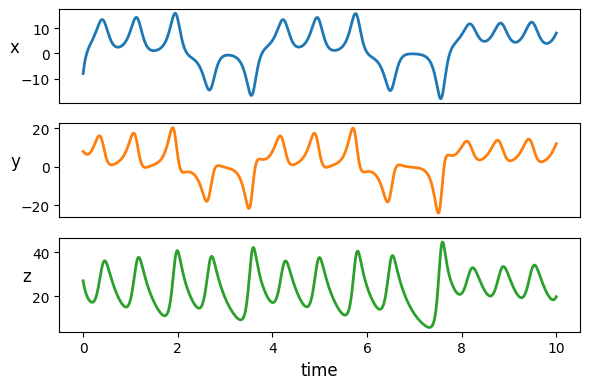

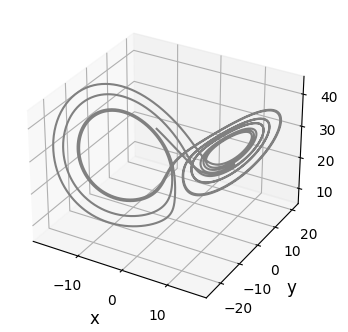

In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import ode

def generate_lorenz_data(t):
    """
    Given a time vector t = t1, t2, ..., evaluates and returns the snapshots
    of the Lorenz system as columns of the matrix X via explicit Runge-Kutta.
    """
    def lorenz_system(t, state, par):
        """
        Defines the system of differential
        equations y'(t) = f(t, y, params).
        """
        x, y, z = state
        sigma, rho, beta = par
        x_dot = sigma * (y - x)
        y_dot = (x * (rho - z)) - y
        z_dot = (x * y) - (beta * z)
        return np.array([x_dot, y_dot, z_dot])

    # Chaotic Lorenz parameters.
    sigma, rho, beta = 10, 28, 8/3

    # Initial condition.
    initial = np.array([-8, 8, 27])

    # Generate Lorenz system data.
    X = np.empty((3, len(t)))
    X[:, 0] = initial
    r = ode(lorenz_system).set_integrator("dopri5")
    r.set_initial_value(initial, t[0])
    r.set_f_params((sigma, rho, beta))
    for i, ti in enumerate(t):
        if i == 0:
            continue
        r.integrate(ti)
        X[:, i] = r.y

    return X

# Generate chaotic Lorenz System data.
dt = 0.002
t = np.arange(0, 10, dt)
X = generate_lorenz_data(t)

# Plot the time-series data.
plt.figure(figsize=(6, 4), dpi=100)
labels = ["x", "y", "z"]
colors = ["tab:blue", "tab:orange", "tab:green"]
for i, (label, color) in enumerate(zip(labels, colors)):
    plt.subplot(3, 1, i + 1)
    plt.plot(t, X[i], c=color, lw=2)
    plt.ylabel(label, rotation=0, fontsize=12)
    if i == 2:
        plt.xlabel("time", fontsize=12)
    else:
        plt.xticks([])
plt.tight_layout()
plt.show()

# Plot the attractor.
ax = plt.figure(figsize=(5, 4), dpi=100).add_subplot(projection="3d")
ax.plot(X[0], X[1], X[2], c="gray")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_zlabel("z", fontsize=12)
plt.show()

# Apply SINDy

In [2]:
# Use second-order centered finite difference to approximate derivatives.
differentiation_method = ps.FiniteDifference(order=2)

# Use polynomials up to degree 5 for the feature library.
feature_library = ps.PolynomialLibrary(degree=5)

# Use sequentially thresholded least for sparse-regression.
optimizer = ps.STLSQ(threshold=0.2)

# Build the SINDy model.
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y", "z"],
)

# Fit the SINDy model to our data.
model.fit(X.T, t=t)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


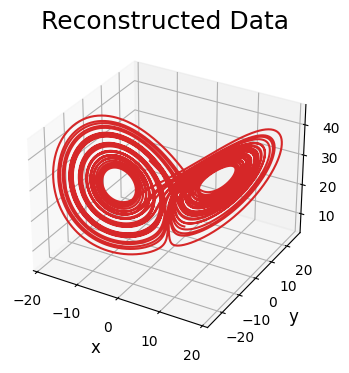

In [3]:
# Compute reconstruction over longer time span.
t_long = np.arange(0, 50, dt)
X_recon = model.simulate(x0=X[:,0], t=t_long).T

# Plot the reconstruction.
ax = plt.figure(figsize=(4, 5), dpi=100).add_subplot(projection="3d")
ax.plot(X_recon[0], X_recon[1], X_recon[2], c="tab:red")
ax.set_title("Reconstructed Data", fontsize=18)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_zlabel("z", fontsize=12)
plt.show()